In [300]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import matplotlib.pyplot as plt
#importing libraries

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [301]:
final_df = pd.read_csv("./data_cleaned/final_df.csv")
final_df.rename(columns = {"Unnamed: 0":"date"},inplace=True)
final_df.set_index(final_df["date"],inplace=True)
final_df.drop(columns = ["date"],inplace=True)

In [302]:
df = final_df.copy()


In [303]:
df.columns

Index(['avg_expenditure_25_34', 'avg_expenditure_35_44',
       'avg_expenditure_45_54', 'avg_expenditure_55_64', 'CPI',
       'employees_construction', 'GDP', 'HCAI_GOVT', 'HCAI_GSE', 'HCAI_PP',
       'home-ownership-rate', 'houses-for-sale-to-sold',
       'industrial_production_cement', '0', 'MORTGAGE30US',
       'pvt_owned_house_under_const', 'nonresidential_const_val', 'permits',
       'personal_saving_rate', 'population', 'house_units_completed',
       'producer_price_index_concrete_brick', 'residential_const_val',
       'retail_sales_home_furnishing_stores', 'target', 'UNRATE',
       'unrate_construction'],
      dtype='object')

In [306]:
# Log transformation to remove outliers
df["unrate_construction"] = np.log(df["unrate_construction"])
df["houses-for-sale-to-sold"] = np.log(df["houses-for-sale-to-sold"])


df["avg_expenditure_35_54"] = df["avg_expenditure_35_44"] + df["avg_expenditure_45_54"]

# Adding GDP per capita
df["gdp_per_capita"] = df["GDP"] / df["population"]

### CPI above 0 or below 0

In [307]:
# Adding a categorical variable to gauge CPI TREND
df["CPI_TREND"] = df["CPI"].apply(lambda x : "UP" if x > 0 else "DOWN")
df["CPI_TREND"].value_counts()

UP      170
DOWN     70
Name: CPI_TREND, dtype: int64

### Growth in GDP - past 12 months

In [367]:

df["GDP_RATE"] = np.log(df["GDP"]/df["GDP"].shift(12))


## GDP trend

In [368]:
# Adding a categorical variable to gauge GDP TREND
df["GDP_TREND"] = df["GDP_RATE"].apply(lambda x : "UP" if x > 0 else "DOWN")

## Growth in number of construction employees

In [310]:
df["EMP_CONST_RATE"] = np.log(df["employees_construction"]/df["employees_construction"].shift(12))

## Trend in number of employees construction

In [311]:
# Adding a categorical variable to gauge trend in number of construction employees
df["EMP_CONST_TREND"] = df["EMP_CONST_RATE"].apply(lambda x : "UP" if x > 0 else "DOWN")

In [312]:
# Since HCAI_GOVT, HCAI_GSE AND HCAI_PP are highly collinear with each other, we are linearly combining them 
df["HCAI"] = (df["HCAI_GOVT"] + df["HCAI_GSE"] + df["HCAI_PP"])/3


## Rate of change of houses for sale to sold - house supply

In [200]:
df["houses_for_sale_to_sold_rate"] = np.log(df["houses_for_sale_to_sold"]/df["houses_for_sale_to_sold"].shift(12))


## Trend in house supply

In [201]:
df["HOUSES_S2S_TREND"] = df["houses_for_sale_to_sold_rate"].apply(lambda x : "UP" if x > 0 else "DOWN")

### Analyzing correlation with derivates of features

In [320]:
for column in df.columns:
    try:
        temp_rate = np.log(df[column]/df[column].shift(12)).dropna()
        temp_cum = df[column].cumsum()
        
        temp_rate_cum = np.log(temp_cum/temp_cum.shift(12)).dropna()
        print()
        print(column,round(df.corr()["target"][column],2))
        trate12 = np.corrcoef(df["target"][12:],temp_rate)[0,1]
        print(f"Correlation between target variable and 12 months change of rate {round(trate12,2)}")
        
        tcum = (np.corrcoef(df["target"],temp_cum)[0,1])
        print(f"correlation cumulative {round(tcum,2) }")
        
        tcumrate = np.corrcoef(df["target"][12:],temp_rate_cum)[0,1]
        print(f"correlation cumulative rate {round(tcumrate,2) }")
        

        
    except:
        continue


avg_expenditure_25_34 0.86
Correlation between target variable and 12 months change of rate 0.25
correlation cumulative 0.76
correlation cumulative rate -0.5

avg_expenditure_35_44 0.88
Correlation between target variable and 12 months change of rate 0.38
correlation cumulative 0.76
correlation cumulative rate -0.49

avg_expenditure_45_54 0.85
Correlation between target variable and 12 months change of rate 0.07
correlation cumulative 0.76
correlation cumulative rate -0.5

avg_expenditure_55_64 0.85
Correlation between target variable and 12 months change of rate -0.0
correlation cumulative 0.76
correlation cumulative rate -0.5

CPI -0.02

employees_construction 0.57
Correlation between target variable and 12 months change of rate 0.27
correlation cumulative 0.76
correlation cumulative rate -0.48

GDP 0.81
Correlation between target variable and 12 months change of rate -0.14
correlation cumulative 0.77
correlation cumulative rate -0.5

HCAI_GOVT -0.38
Correlation between target varia

## Adding cumulative sum and rate of change
* industrial_production_cement
* CPI
* houses_for_sale_to_sold
* pvt_owned_house_under_const
* house_units_completed


In [203]:
df["industrial_production_cement_cum"] = df["industrial_production_cement"].cumsum()
df["cpi_cum"] = df["CPI"].cumsum()

df["houses_for_sale_to_sold_cum"] = df["houses_for_sale_to_sold"].cumsum()
df["private_job_gains_cum"] = df["private_job_gains"].cumsum()
df["pvt_owned_house_under_const_cum"] = df["pvt_owned_house_under_const"].cumsum()
 
df["permits_cum"] = df["permits"].cumsum()

df["house_units_completed_cum"] = df["house_units_completed"].cumsum()

 


## Rate of change of industrial_production_cement_cum
df["industrial_production_cement_rate"] = np.log(df["industrial_production_cement_cum"]/df["industrial_production_cement_cum"].shift(12))

df["pvt_owned_house_under_const_rate"] = np.log(df["pvt_owned_house_under_const_cum"]/df["pvt_owned_house_under_const_cum"].shift(12))

df["permits_rate"] = np.log(df["permits_cum"]/df["permits_cum"].shift(12))

df["private_job_gains_rate"] = np.log(df["private_job_gains_cum"]/df["private_job_gains_cum"].shift(12))


df["pvt_owned_house_under_const_rate"] = np.log(df["pvt_owned_house_under_const_cum"]/df["pvt_owned_house_under_const_cum"].shift(12))


df["house_units_completed_rate"] = np.log(df["house_units_completed_cum"]/df["house_units_completed_cum"].shift(12))


df["private_job_gains_rate"] = np.log(df["private_job_gains_cum"]/df["private_job_gains_cum"].shift(12))


df["private_job_gains_rate"] = np.log(df["private_job_gains_cum"]/df["private_job_gains_cum"].shift(12))



### Adding features to gauge trend

In [204]:
df["PERMITS_TREND"] =  df["permits_rate"].apply(lambda x : "UP" if x > 0 else "DOWN")
df["private_job_gains_trend"] =  df["private_job_gains_rate"].apply(lambda x : "UP" if x > 0 else "DOWN")
df["pvt_owned_house_under_const_trend"] =  df["pvt_owned_house_under_const_rate"].apply(lambda x : "UP" if x > 0 else "DOWN")

df["house_units_completed_trend"] =  df["house_units_completed_rate"].apply(lambda x : "UP" if x > 0 else "DOWN")

In [ ]:
# df.corr()["target"][abs(df.corr()["target"])>0.5]
# df.to_csv("data_cleaned/final_df_added_features.csv")

* Feature engineering - ends

In [339]:
final_df = pd.read_csv("data_cleaned/final_df_added_features.csv")
final_df.rename(columns = {"Unnamed: 0":"date"},inplace=True)
final_df.set_index(final_df["date"],inplace=True)
final_df.drop(columns = ["date"],inplace=True)

In [354]:
final_df = pd.get_dummies(final_df,drop_first=True).dropna()
train = final_df[:"2015"]
test = final_df["2016":]

trainx = train.loc[:,train.columns!="target"]
trainy = train["target"]

testx = test.loc[:,test.columns!="target"]
testy = test["target"]

X = trainx.copy()
y = trainy.copy()


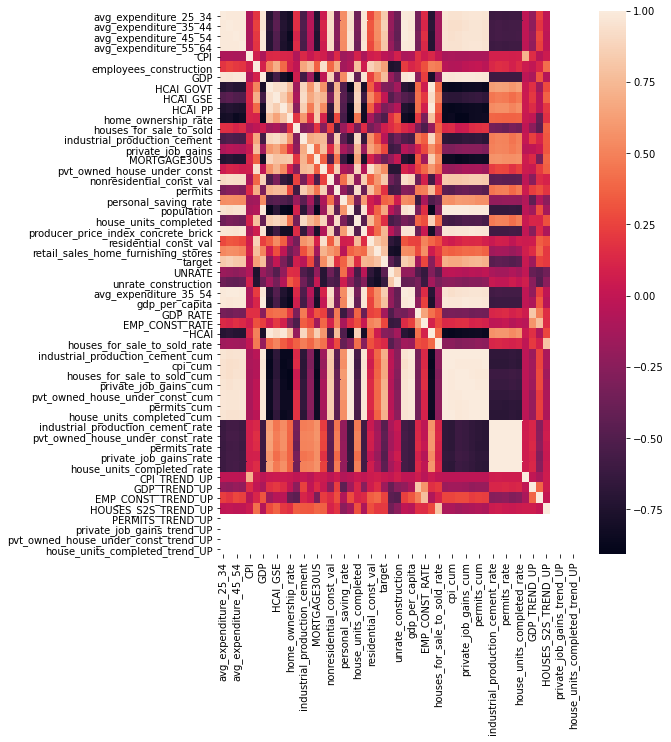

In [355]:
sns.heatmap(final_df.corr())

## Multicollinearity

* There exists a high correlation between independent variables, hence to use linear model, we have to use L1 regularization


#### Feature scaling

In [356]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [357]:
testx = scaler.transform(testx)

In [358]:
#Initializing lassoCV instance
reg = LassoCV()
# Fitting the instance
reg.fit(X, y)
print(f"Best alpha using built-in LassoCV: {round(reg.alpha_,5)}")

print(f"Best score using built-in LassoCV:{round(reg.score(testx,testy),4)}")

coef = pd.Series(reg.coef_, index = trainx.columns)

Best alpha using built-in LassoCV: 0.01356
Best score using built-in LassoCV:0.8387


#### Features selected by the model

In [359]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 28 variables and eliminated the other 24 variables


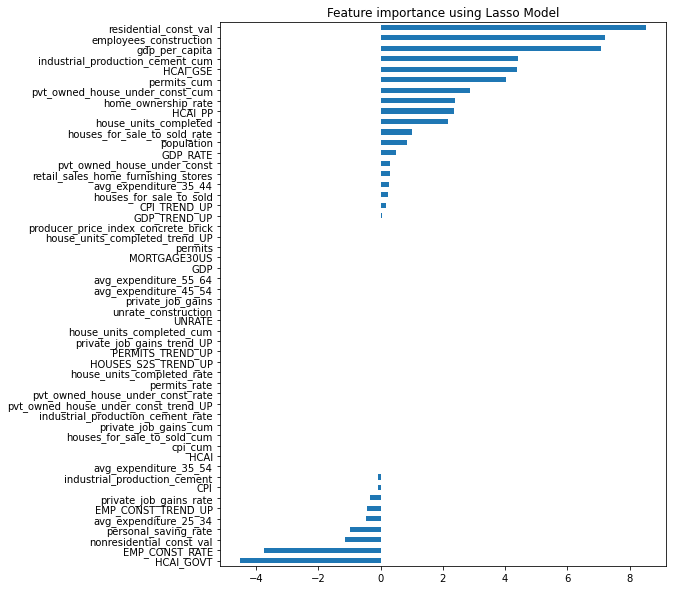

In [360]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

plt.savefig("./images/featimp.png")

## Features which gets eliminated

In [361]:
coef[coef==0]

avg_expenditure_45_54                  -0.0
avg_expenditure_55_64                  -0.0
GDP                                     0.0
private_job_gains                      -0.0
MORTGAGE30US                            0.0
permits                                 0.0
producer_price_index_concrete_brick    -0.0
UNRATE                                  0.0
unrate_construction                     0.0
avg_expenditure_35_54                   0.0
HCAI                                   -0.0
cpi_cum                                -0.0
houses_for_sale_to_sold_cum             0.0
private_job_gains_cum                   0.0
house_units_completed_cum               0.0
industrial_production_cement_rate      -0.0
pvt_owned_house_under_const_rate       -0.0
permits_rate                           -0.0
house_units_completed_rate             -0.0
HOUSES_S2S_TREND_UP                     0.0
PERMITS_TREND_UP                        0.0
private_job_gains_trend_UP              0.0
pvt_owned_house_under_const_tren

### Features with non zero coefficients

In [366]:
((coef[coef!=0]).sort_values(ascending=False))

residential_const_val                  8.522123
employees_construction                 7.202071
gdp_per_capita                         7.075599
industrial_production_cement_cum       4.421657
HCAI_GSE                               4.366235
permits_cum                            4.031410
pvt_owned_house_under_const_cum        2.859470
home_ownership_rate                    2.373083
HCAI_PP                                2.350209
house_units_completed                  2.175655
houses_for_sale_to_sold_rate           1.015123
population                             0.859498
GDP_RATE                               0.495746
pvt_owned_house_under_const            0.286402
retail_sales_home_furnishing_stores    0.284348
avg_expenditure_35_44                  0.275713
houses_for_sale_to_sold                0.224290
CPI_TREND_UP                           0.179261
GDP_TREND_UP                           0.036036
industrial_production_cement          -0.076664
CPI                                   -0

## Metrics

In [363]:
mse = mean_squared_error(reg.predict(testx),testy)
print(f" MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f" R2  = {round(reg.score(testx,testy),4)}")


 MSE = 35.23196017633148
RMSE = 5.935651621880404
 R2  = 0.8387


## Visualizing predictions

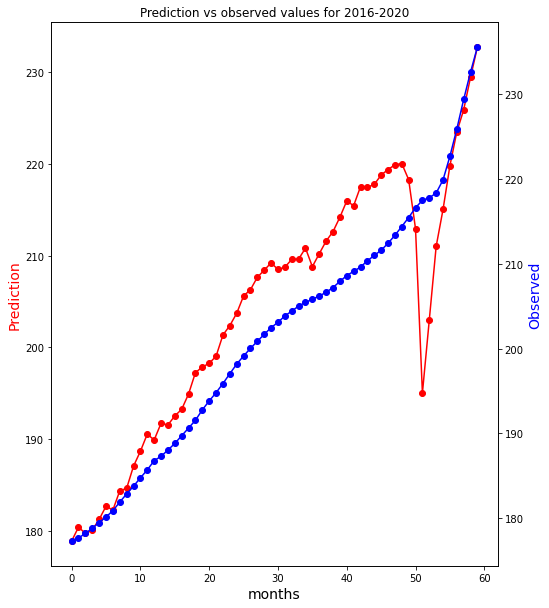

In [364]:

fig,ax = plt.subplots()
# make a plot
ax.plot(range(60), reg.predict(testx), color="red", marker="o")
# set x-axis label
ax.set_xlabel("months",fontsize=14)
# set y-axis label
ax.set_ylabel("Prediction",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(range(60),testy,color="blue",marker="o")
ax2.set_ylabel("Observed",color="blue",fontsize=14)
plt.title(label = "Prediction vs observed values for 2016-2020")
plt.show()
